## Введение в компьютерное зрение (CV): калибровка камеры

Что почитать:
* Конушин А. Геометрические свойства нескольких изображений: https://masters.donntu.ru/2020/etf/azin/library/article4.htm
* Примеры дисторсии и дугих искажений: https://help.autodesk.com/view/ARNOL/ENU/?guid=arnold_user_guide_ac_cameras_ac_perspective_camera_html
* Туториал OpenCV: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

![img](https://help.autodesk.com/cloudhelp/ENU/AR-Core/images/ac-perspective-camera-radial-distortion-man-2-3.gif)

Любая камера, которая используется для работы не идеальна. Матрица смещена относительно центра линзы, линза кривая, FOV настолько большой, что у людей на катринках носы больше головы. Чтобы компенсировать искажения, людьми были придуманы некоторые алгоритмы. Но сначала теория:

### 1. Немного теории
Презентации: 
* (стр. 1-10) http://www.myshared.ru/slide/1351161/
* https://3d.bk.tudelft.nl/courses/geo1016/slides/Lecture_03_Calibration.pdf
* https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

Радиальная дисторсия be like:

![distortion](https://docs.opencv.org/4.x/distortion_examples.png)

Примеры калибровочных шаблонов:

![templates](https://www.researchgate.net/profile/Andrew-Hieu-Nguyen/publication/323782425/figure/fig3/AS:1112642001350662@1642285933669/Example-of-four-commonly-used-camera-calibration-targets.png)

### 2. Практика


Теоретическая задачка на разогрев. Определите параметры матрицы внутренней калибровки для камеры Panasonic DMC-FZ20

https://www.dpreview.com/products/panasonic/compacts/panasonic_dmcfz20/specifications


In [1]:
!pip install matplotlib numpy opencv-python

Ниже ячейка, где вы можете сфотографировать свои шаблоны. Фото делается по пробелу, выход из программы - escape. Фотографии сохраняются в папку `images/`

In [2]:
#import take_photos
#take_photos.main(0) # Input: number of camera

Найдем углы квадратов шаблона:

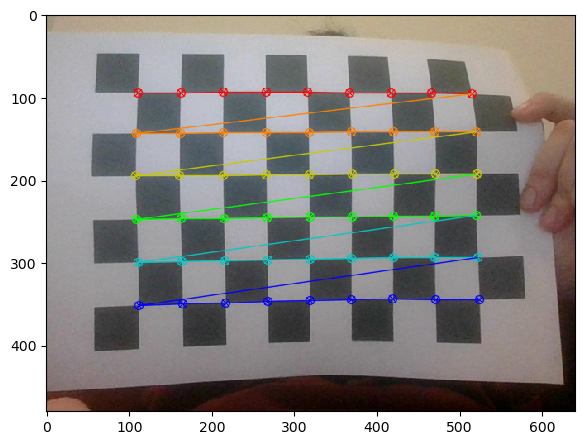

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import glob

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('images/img6.png')

plt.figure(figsize=(15, 60))

for i, fname in enumerate(images):
    img = cv.imread(fname)
    lwr = np.array([0, 0, 117])
    upr = np.array([179, 255, 255])
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    msk = cv.inRange(hsv, lwr, upr)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(msk, (9, 6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (9, 6), corners2, ret)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(int(np.ceil(len(images) / 2)), 2, i + 1)
    plt.imshow(img)

plt.show()

Получаем матрицу камеры, коэффициенты дисторсии, векторы поворотов и положений камеры:

In [4]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx, dist, rvecs, tvecs, sep='\n\n')

[[673.63474463   0.         307.56311461]
 [  0.         666.80272061 247.36353843]
 [  0.           0.           1.        ]]

[[-6.56372531e-01  1.02671782e+01  1.53288502e-02  1.19669425e-03
  -4.47796822e+01]]

(array([[ 0.01653682],
       [-0.04787486],
       [-0.01130534]]),)

(array([[-3.81889623],
       [-3.00736846],
       [12.74688883]]),)


Что вы можете сказать о моей камере?

А что там с дисторсией?

![shrek](https://media.tenor.com/Q1u49-ExrvMAAAAC/shrek-distorted.gif)

Посчитаем новую матрицу камеры:

In [5]:
img = cv.imread('images/img6.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
print(newcameramtx, roi, sep='\n\n')

[[672.58215332   0.         307.08253716]
 [  0.         578.07739258 228.36472999]
 [  0.           0.           1.        ]]

(0, 14, 639, 415)


Сделаем undistort и нарисуем, что получилось:

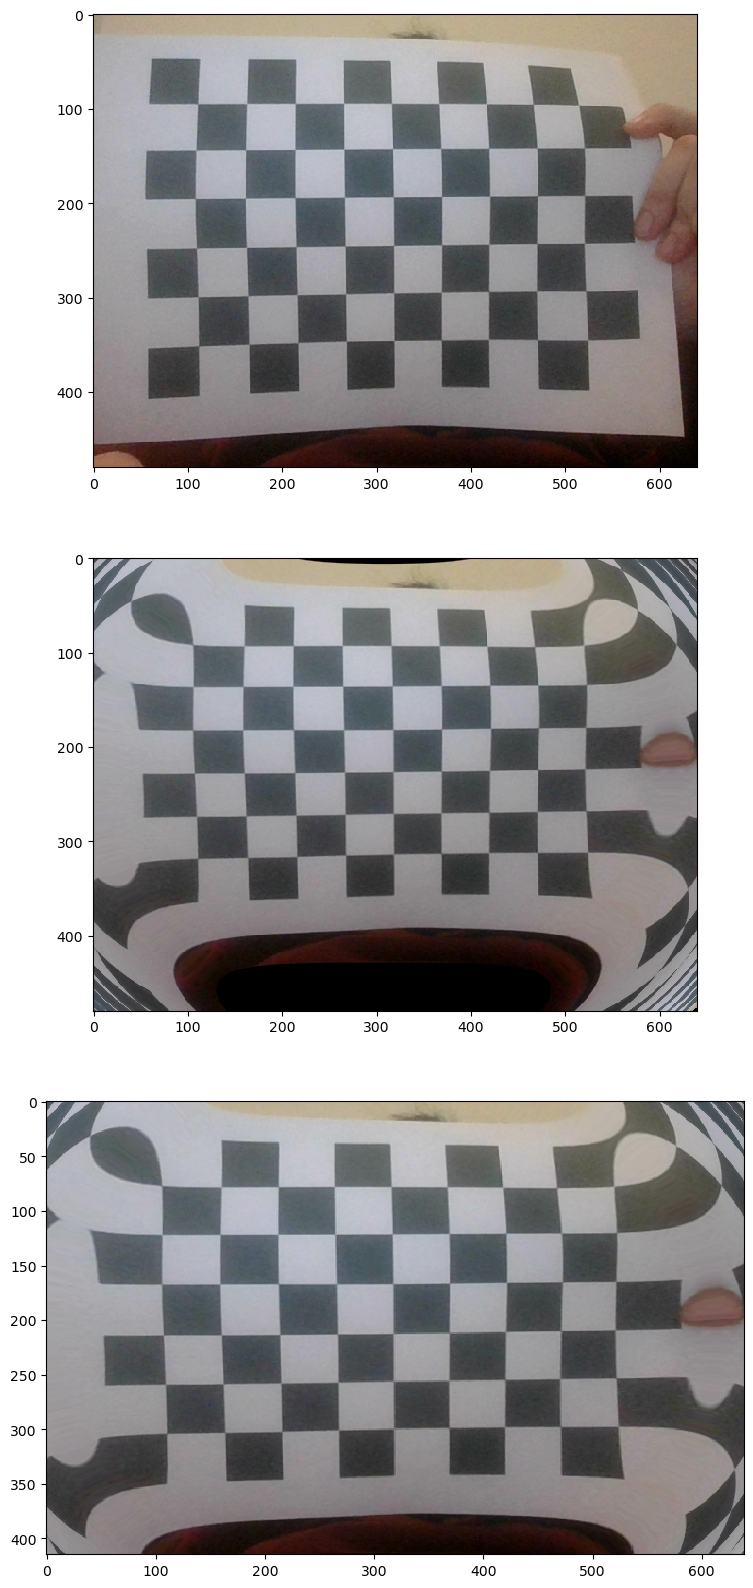

In [6]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
cropped = dst[y:y+h, x:x+w]

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
cropped = cv.cvtColor(cropped, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 20))

plt.subplot(3, 1, 1)
plt.imshow(img)
plt.subplot(3, 1, 2)
plt.imshow(dst)
plt.subplot(3, 1, 3)
plt.imshow(cropped)
plt.show()

Еще примеры:

![before](https://i.stack.imgur.com/xNc5k.jpg)
![after](https://i.stack.imgur.com/O9osX.jpg)

Посчитаем, насколько в целом пикселей я промахнулся:

In [7]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.16119562761028872


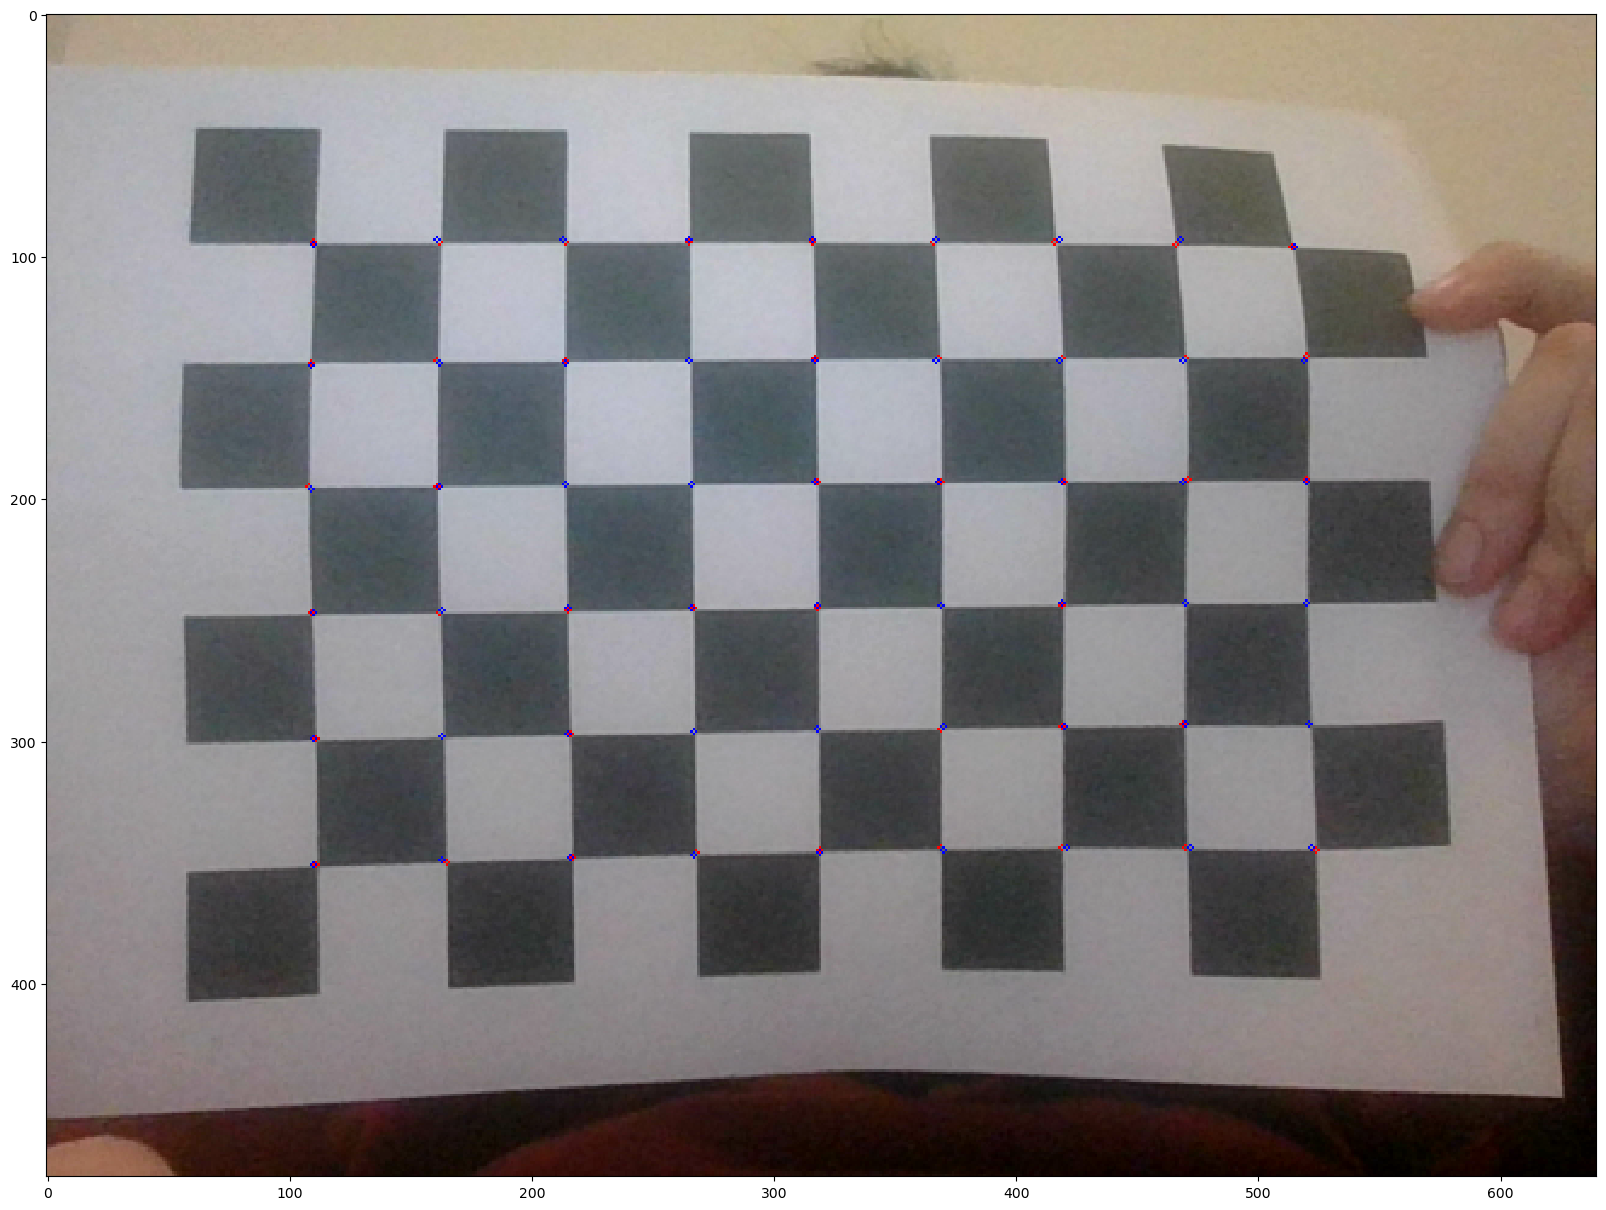

In [8]:
img = cv.imread('images/img6.png')

imgpoints2, _ = cv.projectPoints(objpoints[0], rvecs[0], tvecs[0], mtx, dist)
cur_imgpoints = np.array(imgpoints[0])

for i in range(imgpoints2.shape[0]):
    img = cv.circle(img, cur_imgpoints[i, 0].astype('int'), 1, (0, 0, 255), 1)
    img = cv.circle(img, imgpoints2[i, 0].astype('int'), 1, (255, 0, 0), 1)

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(20, 40))
plt.imshow(img)
plt.show()

### 3. Задания для самостоятельной работы
1) Определите параметры матрицы внутренней калибровки для камеры Panasonic DMC-FZ20.

In [ ]:
При разрешении 2560 x 1920 и минимальном фокусном расстоянии f = 36 мм: fx = 15153, fy = 15153, cx = 1280, cy = 960

2) Прокомментируйте полученные мною значения матрицы внутренней калибровки. Какие параметры матрицы моей камеры можно сказать, а какие нельзя?


In [ ]:
Можно получить размеры матрицы камеры (в пикселях) и ее фокусное расстояние (в пикселях), размеры матрицы в метрах узнать нельзя

3) Определите матрицу внутренней калибровки своей камеры, а также коэффициенты дисторсии.

In [ ]:
Матрица внутренней калибровки:[[672.58215332   0.         307.08253716]
                                [  0.         578.07739258 228.36472999]
                                [  0.           0.           1.        ]]
Коэффициенты дисторсии: [[-6.56372531e-01  1.02671782e+01  1.53288502e-02  1.19669425e-03 -4.47796822e+01]]

4. Определите размер листа А4 (любого другого объекта), если знаете расстояние до него (делаете замер расстояния при фотографировании)

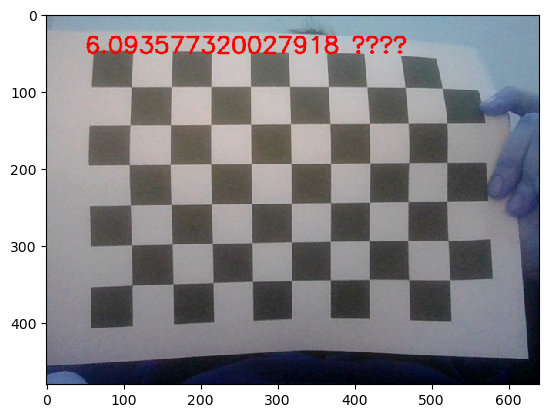

In [9]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
DIST=0.3
mat = np.array([[672.58215332, 0,        307.08253716],
                                [  0,         578.07739258, 228.36472999],
                                [  0,           0,          1        ]])
mat_inv = np.linalg.inv(mat)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
img = cv2.imread('images/img6.png')
gray = np.float32(gray)
d = cv2.cornerHarris(gray,2,3,0.04)
d = cv2.dilate(d,None)
ret, d = cv2.threshold(d,0.01*dst.max(),255,0)
d = np.uint8(d)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(d)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
upper_row = corners[corners[:, 1] < 100]
p_1_px = np.array([upper_row[0, 0], upper_row[0, 1], 1])
p_2_px = np.array([upper_row[1, 0], upper_row[1, 1], 1])
p_1_m = np.dot(mat_inv, p_1_px) * DIST
p_2_m = np.dot(mat_inv, p_2_px) * DIST

d = math.sqrt((p_1_m[0] - p_2_m[0])**2 + (p_1_m[1] - p_2_m[1])**2)

font = cv2.FONT_HERSHEY_SIMPLEX
org = (50, 50)
fontScale = 1
color = (255, 0, 0)
thickness = 2
img = cv2.putText(img, f'{d * 100} см', org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
plt.imshow(img)
plt.show()


### EXTRA супер-дупер задание: сделайте калибровку камеры по шаблону с кругами

В этом поможет: cv2.findСircleGrid

Для начала найдите положение кругов в `patterns/circles_pattern.jpg`

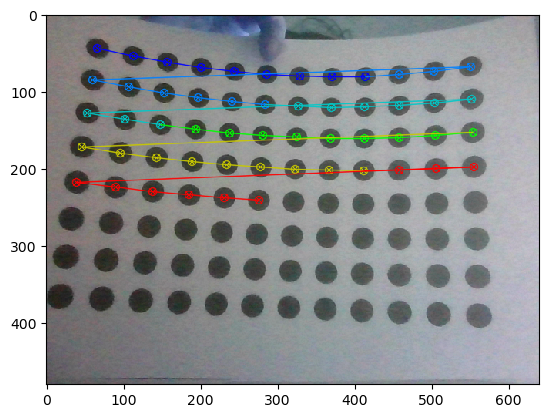

[[2.04158406e+03 0.00000000e+00 3.07589730e+02]
 [0.00000000e+00 4.54604783e+03 5.52217744e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 5.78462405e-01  1.84063272e+02  8.00696212e-02 -7.07703527e-03
  -2.86124621e+03]]


In [16]:
import cv2
import numpy as np
import glob

images = glob.glob('images/img19.png')

objp = np.zeros((12*8, 3), np.float32)
objp[:,:2] = np.mgrid[0:12, 0:8].T.reshape(-1,2)
objpoints = [] 
imgpoints = [] 
imgShape = None

for img in images:
    frame = cv2.imread(img)
    gray = cv2.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if imgShape is None:
        imgShape = gray.shape[::-1]
    retVal, centers = cv2.findCirclesGrid(gray, (12, 8), cv2.CALIB_CB_SYMMETRIC_GRID)

    if retVal == True:
        objpoints.append(objp)
        imgpoints.append(centers)
        cv.drawChessboardCorners(frame, (9, 6), centers, retVal)
    plt.imshow(frame)
    plt.show()


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgShape, None, None)
print(mtx)
print(dist)
